# 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def str_col(df):
    col = []
    for i in range(0,len(df.dtypes)):
        if str(df.dtypes[i]) == 'object':
            col.append(df.dtypes.index[i])
    print(col)        
    return col


def int_col(df):
    col = []
    for i in range(0,len(df.dtypes)):
        if str(df.dtypes[i]) != 'object':
            col.append(df.dtypes.index[i])
    print(col)        
    return col 

def p_100(a, b):
    print( round( (a/(a+b))*100,2), "%" )
    
def extraction_func(df, col_name, num_list):
    temp = pd.DataFrame()
    for i in num_list:
        temp = pd.concat([ temp, df.loc[df[col_name] == i ] ],axis=0)
    return temp    

In [3]:
x_train = pd.read_csv('./temp_data/save_feature_importance.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_train = pd.read_csv('./temp_data/save_y_train.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
x_test = pd.read_csv('./temp_data/save_x_test.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)
y_test = pd.read_csv('./temp_data/save_y_test.csv',encoding='utf-8').rename(columns = {'Unnamed: 0': 'index'}).set_index('index',drop=True)

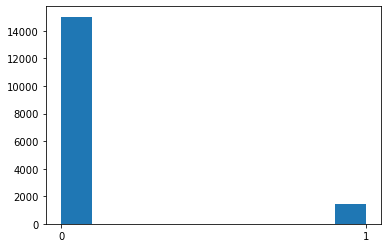

SIU_CUST_YN
0              15028
1               1440
dtype: int64
8.74 %
None


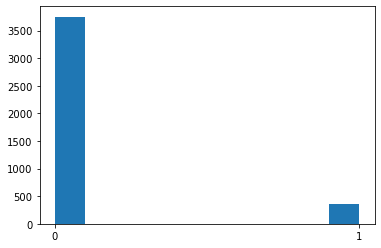

SIU_CUST_YN
0              3751
1               366
dtype: int64
8.89 %
None


In [4]:
y_train = y_train.replace('Y',1)
y_train = y_train.replace('N',0)

y_test = y_test.replace('Y',1)
y_test = y_test.replace('N',0)

plt.hist(y_train)
plt.xticks([0,1])
plt.show()

print(y_train.value_counts())
print(p_100(y_train.value_counts()[1],y_train.value_counts()[0]))

plt.hist(y_test)
plt.xticks([0,1])
plt.show()

print(y_test.value_counts())
print(p_100(y_test.value_counts()[1],y_test.value_counts()[0]))

# 분할적 군집화

##### 군집수인 k를 지정한 후 관측치들을 무작위로 k개의 집단으로 분할하고
##### 평균이나 최반값등을 이용하여 centroid(무게중심)를 수정해나가며 집단을 재분류하는 방법이다.

 - clustering을 통해 유지하는 집단과 탈락하는 집단을 추출
 - 학습데이터셋의 중도탈락률이 8.74%.
 - 따라서 보험사기자가 아닌 집단은 사기자 비율의 절반인 약 5% 이하의 그룹, 보험사기자 집단은 사기자 비율의 2배인 약 15% 이상의 그룹으로 나눔
 - elbowpoint : 각 데이터 요소와 해당 중심 사이의 거리를 측정하고 이 거리를 제곱한 다음 하나의 클러스터에서 이 제곱을 합산하여 계산
 - silhouette : 요소들 간 거리들의 평균을 군집마다 각각 구한 뒤, 이 가운데 가장 작은 값

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

##### yellowbrick라는 패키지를 사용하면 더 보기 쉽게 elbow를 알려준다

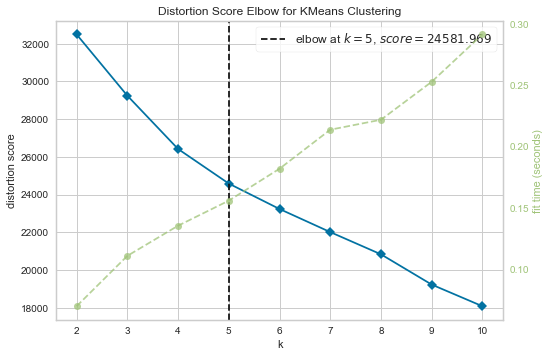

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

x_train_copy = x_train.copy()
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,11))
visualizer.fit(x_train_copy)
visualizer.show()

In [7]:
from sklearn.metrics import silhouette_score

x_train_copy = x_train.copy()

k_range = range(2,11)

best_n = -1
best_silhouette_score = -1

for k in k_range:
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_train_copy)
    clusters = kmeans.predict(x_train_copy)
    
    score = silhouette_score(x_train_copy,clusters)
    print('k :', k,'score :', score)
    
    if score > best_silhouette_score:
        best_n = k
        best_silhouette_score= score
print('best n:', best_n, 'best score :', best_silhouette_score)        

k : 2 score : 0.21660257394232474
k : 3 score : 0.17975047943669017
k : 4 score : 0.20127537452816058
k : 5 score : 0.19742096543808163
k : 6 score : 0.21852918913919908
k : 7 score : 0.2241139103461554
k : 8 score : 0.22660293420667893
k : 9 score : 0.2334418604628015
k : 10 score : 0.2609327707748894
best n: 10 best score : 0.2609327707748894


5 개로 군집화
label  cluster
0      0          3671
       1          3781
       2          2942
       3          2607
       4          2027
1      0           400
       1           482
       2           261
       3            89
       4           208
Name: AGE, dtype: int64

0 번째 군집 중도탈락 비율 : 9.83 %
1 번째 군집 중도탈락 비율 : 11.31 %
2 번째 군집 중도탈락 비율 : 8.15 %
3 번째 군집 중도탈락 비율 : 3.3 %
4 번째 군집 중도탈락 비율 : 9.31 %

5 개로 군집화
(16468, 3)
설명력 :  0.6713178529635073


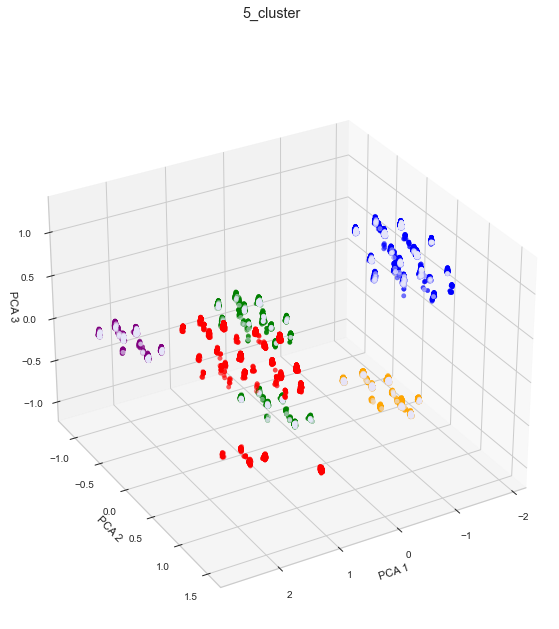

In [8]:
label_data = y_train.copy()
x_train_copy = x_train.copy()

cluster_num = 5

km = KMeans(n_clusters=cluster_num ,init='k-means++', random_state=42)
km.fit(x_train_copy)

label_data = label_data.replace('유지',0)
label_data = label_data.replace('탈락',1)

x_train_copy['label'] = label_data

x_train_copy['cluster'] = km.labels_

cluster_result = x_train_copy.groupby(['label','cluster'])['AGE'].count()
print(cluster_num,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인
print()

if len(cluster_result[1]) >= len(cluster_result[0]):
    length = cluster_result[0].index
else:    
    length = cluster_result[1].index
    
for j in length:
    print(j,"번째 군집 중도탈락 비율 : ",end="")
    p_100(cluster_result[1][j],cluster_result[0][j])
    
# 차원축소
pca = PCA(n_components=3)
pca.fit(x_train_copy)
data_pca = pca.transform(x_train_copy)

print()
print(cluster_num,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

x_train_copy['pca_x'] = data_pca[:,0]
x_train_copy['pca_y'] = data_pca[:,1]
x_train_copy['pca_z'] = data_pca[:,2]

arr = [0 for n in range(cluster_num+1)]
base_color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan']

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for j in range(0, cluster_num):
    arr[j] = x_train_copy.loc[x_train_copy['cluster'] == j].index

arr[cluster_num] = x_train_copy.loc[x_train_copy['label'] == 1].index   

for j in range(0,len(arr)-1):
    ax.scatter(xs=x_train_copy.loc[arr[j],'pca_x'], ys=x_train_copy.loc[arr[j],'pca_y'], zs=x_train_copy.loc[arr[j],'pca_z'], c=base_color[j])

ax.scatter(xs=x_train_copy.loc[arr[len(arr)-1],'pca_x'], ys=x_train_copy.loc[arr[len(arr)-1],'pca_y'], zs=x_train_copy.loc[arr[len(arr)-1],'pca_z'], c='lavender')

ax.view_init(30,60) # 0,60  / 0,0
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
globals()['{}__cluster'.format(cluster_num)] = "{}_cluster".format(cluster_num)
plt.suptitle(globals()['{}__cluster'.format(cluster_num)])
plt.show()

In [9]:
cluster_0 = x_train_copy.loc[x_train_copy['cluster'] == 0].drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1)
cluster_1 = x_train_copy.loc[x_train_copy['cluster'] == 1].drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1)
cluster_2 = x_train_copy.loc[x_train_copy['cluster'] == 2].drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1)
cluster_3 = x_train_copy.loc[x_train_copy['cluster'] == 3].drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1)
cluster_4 = x_train_copy.loc[x_train_copy['cluster'] == 4].drop(['label','cluster','pca_x','pca_y','pca_z'], axis=1)

#### 2차 군집
 - 1차 군집 결과 목표하던 수치를 가진 집단이 없으므로 2차 군집 진행

##### 2차 
 - 0번

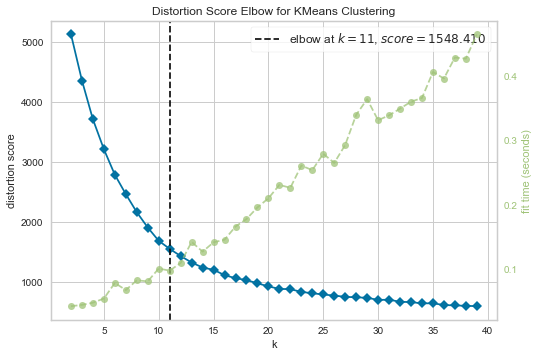

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,40))
visualizer.fit(cluster_0)
visualizer.show()

11 개로 군집화
label  cluster
0      0          369
       1          447
       2          353
       3          711
       4          377
       5          276
       6          169
       7          274
       8          314
       9          246
       10         135
1      0           54
       1           48
       2           29
       3           64
       4           11
       5           52
       6           32
       7           65
       8            8
       9           16
       10          21
Name: AGE, dtype: int64

0 번째 군집 중도탈락 비율 : 12.77 %
1 번째 군집 중도탈락 비율 : 9.7 %
2 번째 군집 중도탈락 비율 : 7.59 %
3 번째 군집 중도탈락 비율 : 8.26 %
4 번째 군집 중도탈락 비율 : 2.84 %
5 번째 군집 중도탈락 비율 : 15.85 %
6 번째 군집 중도탈락 비율 : 15.92 %
7 번째 군집 중도탈락 비율 : 19.17 %
8 번째 군집 중도탈락 비율 : 2.48 %
9 번째 군집 중도탈락 비율 : 6.11 %
10 번째 군집 중도탈락 비율 : 13.46 %

11 개로 군집화
(4071, 2)
설명력 :  0.8837528680153608


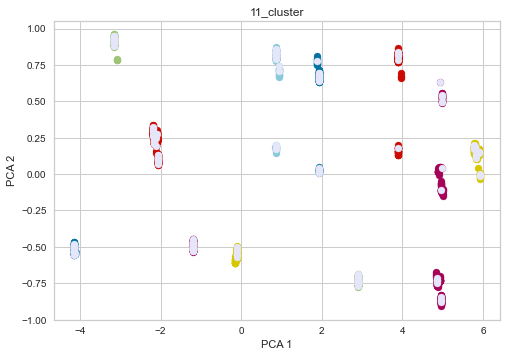

In [11]:
label_data = y_train.copy()
cluster_copy = cluster_0.copy()

cluster_num = 11

km = KMeans(n_clusters=cluster_num ,init='k-means++', random_state=42)
km.fit(cluster_copy)

label_data = label_data.replace('유지',0)
label_data = label_data.replace('탈락',1)

cluster_copy['label'] = label_data

cluster_copy['cluster'] = km.labels_

cluster_result = cluster_copy.groupby(['label','cluster'])['AGE'].count()
print(cluster_num,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인
print()

if len(cluster_result[1]) >= len(cluster_result[0]):
    length = cluster_result[0].index
else:    
    length = cluster_result[1].index
    
for j in length:
    print(j,"번째 군집 중도탈락 비율 : ",end="")
    p_100(cluster_result[1][j],cluster_result[0][j])
    
# 차원축소
pca = PCA(n_components=2)
pca.fit(cluster_copy)
data_pca = pca.transform(cluster_copy)

print()
print(cluster_num,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

cluster_copy['pca_x'] = data_pca[:,0]
cluster_copy['pca_y'] = data_pca[:,1]

arr = [0 for n in range(cluster_num+1)]

for j in range(0,cluster_num):
    arr[j] = cluster_copy.loc[cluster_copy['cluster'] == j].index

arr[cluster_num] = cluster_copy.loc[cluster_copy['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=cluster_copy.loc[arr[j],'pca_x'], y=cluster_copy.loc[arr[j],'pca_y'])

plt.scatter(x=cluster_copy.loc[arr[len(arr)-1],'pca_x'], y=cluster_copy.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(cluster_num)] = "{}_cluster".format(cluster_num)
plt.title(globals()['{}__cluster'.format(cluster_num)])
plt.show()

In [12]:
list_cluster = [4, 8]

cluster_0_copy_N = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_0_copy_N

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
14639,0.125216,0.000279,0.000000,0.000350,0.005793,0.029908,0.512885,0.241379,0.369030,0.164948,...,0,1,0,0,0,0,0,4,-0.147841,-0.594549
19807,0.008027,0.000195,0.000000,0.000612,0.005793,0.012229,0.371577,0.252874,0.218483,0.041237,...,0,1,0,0,0,0,0,4,-0.113085,-0.557965
18285,0.012843,0.000630,0.000000,0.000950,0.005793,0.010058,0.359927,0.252874,0.177179,0.010309,...,0,1,0,0,0,0,0,4,-0.112949,-0.559299
2662,0.004174,0.001159,0.333333,0.001267,0.065231,0.014575,0.380755,0.620690,0.347181,0.175258,...,0,1,0,0,0,0,0,4,-0.112789,-0.511408
18786,0.101136,0.002055,0.333333,0.000861,0.009048,0.044153,0.308286,0.367816,0.383542,0.185567,...,0,1,0,0,0,0,0,4,-0.146757,-0.564070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14555,0.417846,0.001095,0.333333,0.000998,0.009750,0.025762,0.000000,0.528736,0.174707,0.051546,...,0,0,0,0,0,1,0,8,3.896933,0.810225
11649,0.012843,0.000968,0.000000,0.001059,0.003615,0.011514,0.345000,0.655172,0.118970,0.010309,...,0,0,0,0,0,1,0,8,3.895772,0.805528
13808,0.004816,0.000369,0.333333,0.001544,0.060684,0.002825,0.246810,0.540230,0.369030,0.020619,...,0,0,0,0,0,1,0,8,3.896871,0.821294


In [13]:
list_cluster = [5, 6]

cluster_0_copy_Y = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_0_copy_Y

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
16167,0.502470,0.001179,0.000000,0.000384,0.005793,0.003238,0.193303,0.160920,0.369030,0.092784,...,0,0,0,0,0,1,0,5,0.852576,0.781011
1989,0.096855,0.014078,0.333333,0.000261,0.000700,0.093252,0.276968,0.597701,0.369030,0.020619,...,0,0,0,0,0,1,0,5,0.853391,0.832756
13093,0.309187,0.003832,0.333333,0.001203,0.011037,0.144387,0.191084,0.712644,0.155410,0.103093,...,0,0,0,0,0,1,1,5,0.853474,0.833671
10515,0.014448,0.002373,0.000000,0.001498,0.008234,0.019168,0.240355,0.666667,0.369030,0.030928,...,0,0,0,0,0,1,0,5,0.851930,0.813661
6506,0.003211,0.001252,0.500000,0.000633,0.006122,0.003539,0.235968,0.528736,0.369030,0.061856,...,0,0,0,0,0,1,0,5,0.854428,0.845807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9435,0.033557,0.003161,0.500000,0.000672,0.039673,0.003962,0.279187,0.494253,0.369030,0.030928,...,0,0,0,0,0,1,0,6,1.937067,0.699087
7158,0.000000,0.002771,0.166667,0.001481,0.005671,0.073200,0.236119,0.356322,0.191851,0.000000,...,0,0,0,0,0,1,0,6,1.935898,0.663753
14039,0.000000,0.000200,0.166667,0.000488,0.004676,0.009789,0.216299,0.448276,0.369030,0.000000,...,0,0,0,0,0,0,0,6,1.926496,0.015029


##### 2차 
 - 1번

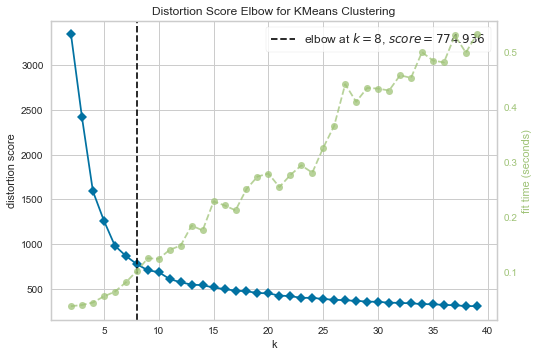

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,40))
visualizer.fit(cluster_1)
visualizer.show()

8 개로 군집화
label  cluster
0      0           410
       1          1444
       2           739
       3           661
       4           197
       5           101
       6           118
       7           111
1      0           105
       1           157
       2           132
       3            22
       4            19
       5            30
       6             2
       7            15
Name: AGE, dtype: int64

0 번째 군집 중도탈락 비율 : 20.39 %
1 번째 군집 중도탈락 비율 : 9.81 %
2 번째 군집 중도탈락 비율 : 15.15 %
3 번째 군집 중도탈락 비율 : 3.22 %
4 번째 군집 중도탈락 비율 : 8.8 %
5 번째 군집 중도탈락 비율 : 22.9 %
6 번째 군집 중도탈락 비율 : 1.67 %
7 번째 군집 중도탈락 비율 : 11.9 %

8 개로 군집화
(4263, 2)
설명력 :  0.8092293438772697


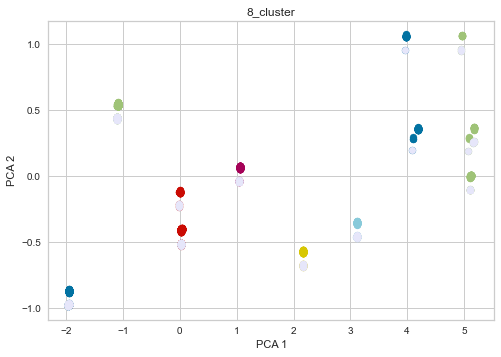

In [15]:
label_data = y_train.copy()
cluster_copy = cluster_1.copy()

cluster_num = 8

km = KMeans(n_clusters=cluster_num ,init='k-means++', random_state=42)
km.fit(cluster_copy)

label_data = label_data.replace('유지',0)
label_data = label_data.replace('탈락',1)

cluster_copy['label'] = label_data

cluster_copy['cluster'] = km.labels_

cluster_result = cluster_copy.groupby(['label','cluster'])['AGE'].count()
print(cluster_num,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인
print()

if len(cluster_result[1]) >= len(cluster_result[0]):
    length = cluster_result[0].index
else:    
    length = cluster_result[1].index
    
for j in length:
    print(j,"번째 군집 중도탈락 비율 : ",end="")
    p_100(cluster_result[1][j],cluster_result[0][j])
    
# 차원축소
pca = PCA(n_components=2)
pca.fit(cluster_copy)
data_pca = pca.transform(cluster_copy)

print()
print(cluster_num,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

cluster_copy['pca_x'] = data_pca[:,0]
cluster_copy['pca_y'] = data_pca[:,1]

arr = [0 for n in range(cluster_num+1)]

for j in range(0,cluster_num):
    arr[j] = cluster_copy.loc[cluster_copy['cluster'] == j].index

arr[cluster_num] = cluster_copy.loc[cluster_copy['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=cluster_copy.loc[arr[j],'pca_x'], y=cluster_copy.loc[arr[j],'pca_y'])

plt.scatter(x=cluster_copy.loc[arr[len(arr)-1],'pca_x'], y=cluster_copy.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(cluster_num)] = "{}_cluster".format(cluster_num)
plt.title(globals()['{}__cluster'.format(cluster_num)])
plt.show()

In [16]:
list_cluster = [3, 6]

cluster_1_copy_N = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_1_copy_N

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
1413,0.441467,0.001198,0.000000,0.000785,0.004291,0.008012,0.641686,0.310345,0.128698,0.041237,...,1,0,0,0,0,0,0,3,1.058697,0.074463
12255,0.385280,0.000903,0.000000,0.000842,0.002535,0.508815,0.000000,0.563218,0.369030,0.061856,...,1,0,0,0,0,0,0,3,1.054680,0.060690
14618,0.033712,0.003173,0.000000,0.001382,0.001272,0.004097,0.258409,0.609195,0.031576,0.000000,...,1,0,0,0,0,0,0,3,1.058883,0.063822
14329,0.031572,0.000861,0.000000,0.001501,0.023331,0.001466,0.442887,0.471264,0.351966,0.010309,...,1,0,0,0,0,0,0,3,1.058440,0.070365
9808,0.372705,0.000437,0.333333,0.000406,0.004468,0.006550,0.226739,0.540230,0.455147,0.041237,...,1,0,0,0,0,0,0,3,1.056421,0.065301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3452,0.003532,0.000500,0.333333,0.001200,0.010846,0.000453,0.362499,0.620690,0.369030,0.000000,...,1,0,0,0,0,0,0,6,4.194313,0.355497
10160,0.008027,0.001653,0.000000,0.001154,0.001804,0.005261,0.512885,0.505747,0.060681,0.010309,...,1,0,0,0,0,0,0,6,3.976730,1.060000
9911,0.021404,0.000131,0.333333,0.000430,0.001910,0.002630,0.292803,0.471264,0.342317,0.051546,...,1,0,0,0,0,0,0,6,4.194257,0.356911


In [17]:
list_cluster = [0, 2, 5]

cluster_1_copy_Y = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_1_copy_Y

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
10353,0.057792,0.000562,0.000000,0.002298,0.022309,0.046594,0.197085,0.839080,0.369030,0.010309,...,1,0,0,0,0,0,0,0,-1.948568,-0.879466
10205,0.013183,0.000400,0.333333,0.000596,0.037356,0.012635,0.305663,0.620690,0.427239,0.010309,...,1,0,0,0,0,0,0,0,-1.947722,-0.870971
5456,0.019264,0.000422,0.333333,0.001667,0.009127,0.020311,0.304453,0.586207,0.456343,0.010309,...,1,0,0,0,0,0,0,0,-1.947822,-0.870511
11285,0.012843,0.003821,0.000000,0.000427,0.005222,0.000862,0.209138,0.517241,0.376366,0.010309,...,1,0,0,0,0,0,0,0,-1.947496,-0.869172
1002,0.163744,0.000240,0.000000,0.000346,0.001126,0.006231,0.219830,0.379310,0.369030,0.020619,...,1,0,0,0,0,0,0,0,-1.947657,-0.866086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9789,0.012843,0.000350,0.166667,0.000738,0.005608,0.001768,0.359272,0.620690,0.415039,0.000000,...,1,0,0,0,0,0,0,5,3.121328,-0.356055
13067,0.017659,0.001648,0.333333,0.001917,0.011690,0.022682,0.479449,0.448276,0.186907,0.000000,...,1,0,0,0,0,0,0,5,3.123440,-0.343447
7629,0.072240,0.000350,0.000000,0.000678,0.007189,0.006835,0.535781,0.643678,0.369030,0.000000,...,1,0,0,0,0,0,0,5,3.121643,-0.354989


##### 2차 
 - 2번

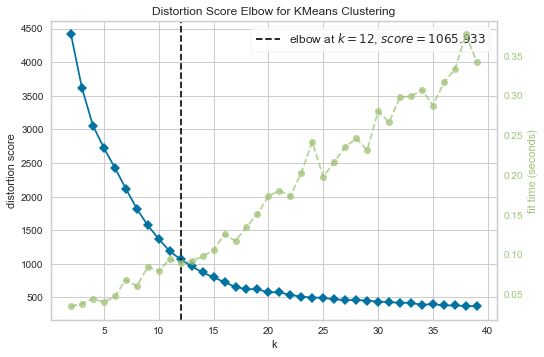

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,40))
visualizer.fit(cluster_2)
visualizer.show()

12 개로 군집화
label  cluster
0      0          354
       1          340
       2          239
       3          138
       4          385
       5          237
       6          140
       7          227
       8          190
       9          198
       10         161
       11         333
1      0           41
       1           29
       2            5
       3            8
       4           28
       5           29
       6           16
       7            7
       8           31
       9           34
       10          10
       11          23
Name: AGE, dtype: int64

0 번째 군집 중도탈락 비율 : 10.38 %
1 번째 군집 중도탈락 비율 : 7.86 %
2 번째 군집 중도탈락 비율 : 2.05 %
3 번째 군집 중도탈락 비율 : 5.48 %
4 번째 군집 중도탈락 비율 : 6.78 %
5 번째 군집 중도탈락 비율 : 10.9 %
6 번째 군집 중도탈락 비율 : 10.26 %
7 번째 군집 중도탈락 비율 : 2.99 %
8 번째 군집 중도탈락 비율 : 14.03 %
9 번째 군집 중도탈락 비율 : 14.66 %
10 번째 군집 중도탈락 비율 : 5.85 %
11 번째 군집 중도탈락 비율 : 6.46 %

12 개로 군집화
(3203, 2)
설명력 :  0.9153626182558132


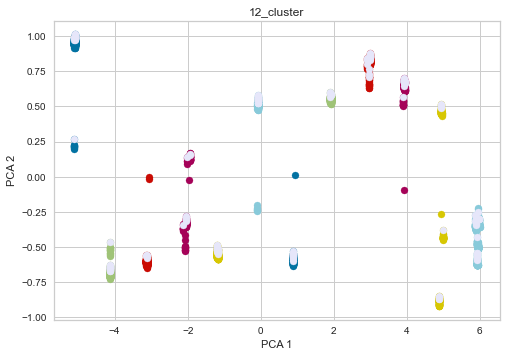

In [19]:
label_data = y_train.copy()
cluster_copy = cluster_2.copy()

cluster_num = 12

km = KMeans(n_clusters=cluster_num ,init='k-means++', random_state=42)
km.fit(cluster_copy)

label_data = label_data.replace('유지',0)
label_data = label_data.replace('탈락',1)

cluster_copy['label'] = label_data

cluster_copy['cluster'] = km.labels_

cluster_result = cluster_copy.groupby(['label','cluster'])['AGE'].count()
print(cluster_num,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인
print()

if len(cluster_result[1]) >= len(cluster_result[0]):
    length = cluster_result[0].index
else:    
    length = cluster_result[1].index
    
for j in length:
    print(j,"번째 군집 중도탈락 비율 : ",end="")
    p_100(cluster_result[1][j],cluster_result[0][j])
    
# 차원축소
pca = PCA(n_components=2)
pca.fit(cluster_copy)
data_pca = pca.transform(cluster_copy)

print()
print(cluster_num,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

cluster_copy['pca_x'] = data_pca[:,0]
cluster_copy['pca_y'] = data_pca[:,1]

arr = [0 for n in range(cluster_num+1)]

for j in range(0,cluster_num):
    arr[j] = cluster_copy.loc[cluster_copy['cluster'] == j].index

arr[cluster_num] = cluster_copy.loc[cluster_copy['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=cluster_copy.loc[arr[j],'pca_x'], y=cluster_copy.loc[arr[j],'pca_y'])

plt.scatter(x=cluster_copy.loc[arr[len(arr)-1],'pca_x'], y=cluster_copy.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(cluster_num)] = "{}_cluster".format(cluster_num)
plt.title(globals()['{}__cluster'.format(cluster_num)])
plt.show()

In [20]:
list_cluster = [2, 7]

cluster_2_copy_N = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_2_copy_N

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
7810,0.000803,0.000857,0.500000,0.003004,0.470510,0.122329,0.394120,0.574713,0.369030,0.041237,...,0,0,0,0,0,1,0,2,-3.132324,-0.619504
14540,0.016053,0.000851,0.166667,0.001836,0.010074,0.012908,0.383580,0.413793,0.189379,0.051546,...,0,0,0,0,0,1,0,2,-3.126499,-0.608401
12529,0.155182,0.000539,0.000000,0.001107,0.016222,0.013734,0.671239,0.459770,0.369030,0.041237,...,0,0,0,0,0,1,0,2,-3.128822,-0.588498
18995,0.055585,0.000323,0.500000,0.001018,0.005869,0.005681,0.472843,0.632184,0.369030,0.030928,...,0,0,0,0,0,1,0,2,-3.133819,-0.609671
7386,0.002076,0.000618,0.166667,0.000498,0.087176,0.002350,0.244339,0.517241,0.422375,0.010309,...,0,0,0,0,0,1,0,2,-3.129813,-0.592502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409,0.004816,0.000297,0.000000,0.001286,0.004070,0.004700,0.267033,0.298851,0.131170,0.010309,...,1,0,0,0,0,0,0,7,1.918650,0.525437
12757,0.000000,0.000201,0.000000,0.001526,0.006141,0.035641,0.335418,0.620690,0.371501,0.010309,...,1,0,0,0,0,0,0,7,1.909356,0.564660
8050,0.040936,0.000239,0.000000,0.000945,0.023426,0.000701,0.463362,0.482759,0.369030,0.010309,...,1,0,0,0,0,0,0,7,1.909979,0.557312


In [21]:
list_cluster = [8, 9]

cluster_2_copy_Y = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_2_copy_Y

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
6072,0.019264,0.001412,0.000000,0.000505,0.003278,0.004420,0.000000,0.712644,0.369030,0.020619,...,1,0,0,0,0,0,0,8,2.912345,0.804981
12440,0.038528,0.001698,0.000000,0.000932,0.003025,0.009789,0.494478,0.505747,0.369030,0.000000,...,1,0,0,0,0,0,0,8,2.993163,0.827408
2310,0.017017,0.000999,0.000000,0.000603,0.030159,0.022812,0.566090,0.471264,0.369030,0.051546,...,1,0,0,0,0,0,0,8,2.992829,0.824341
1280,0.001605,0.000599,0.000000,0.001658,0.066250,0.004851,0.000000,0.367816,0.284108,0.000000,...,1,0,0,0,0,0,0,8,2.997547,0.819451
5211,0.000000,0.047902,0.000000,0.000478,0.011156,0.599400,0.322709,0.471264,0.369030,0.010309,...,1,0,0,0,0,0,0,8,2.956399,0.711173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12183,0.012843,0.015423,0.000000,0.000269,0.001608,0.009789,0.285087,0.597701,0.455147,0.000000,...,1,0,0,0,0,0,0,9,3.898156,0.516849
7400,0.006100,0.000549,0.166667,0.001998,0.007844,0.003461,0.375813,0.574713,0.376366,0.010309,...,1,0,0,0,0,0,0,9,3.928488,0.638603
8004,0.032107,0.000699,0.000000,0.000389,0.006795,0.048848,0.503707,0.494253,0.369030,0.257732,...,1,0,0,0,0,0,0,9,3.929870,0.638419


##### 2차 
 - 3번
   - 3번 군집은 이미 보험사기자가 3%이므로 2차 군집화 안함 

In [22]:
cluster_3_copy_N = cluster_3

##### 2차 
 - 4번

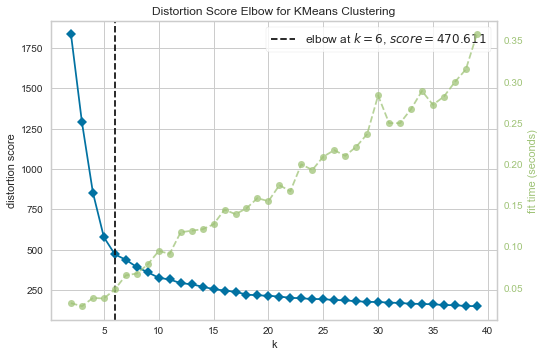

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
# # 파란선은 그룹의 변동성을 확인하는 지표 
# # 세로 점선으로 최적의 군집 개수
# # 녹색 점선은 군집을 학습할 때 걸린 시간이
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,40))
visualizer.fit(cluster_4)
visualizer.show()

6 개로 군집화
label  cluster
0      0          409
       1          147
       2          628
       3          472
       4          271
       5          100
1      0           11
       1           13
       2           54
       3           54
       4           59
       5           17
Name: AGE, dtype: int64

0 번째 군집 중도탈락 비율 : 2.62 %
1 번째 군집 중도탈락 비율 : 8.12 %
2 번째 군집 중도탈락 비율 : 7.92 %
3 번째 군집 중도탈락 비율 : 10.27 %
4 번째 군집 중도탈락 비율 : 17.88 %
5 번째 군집 중도탈락 비율 : 14.53 %

6 개로 군집화
(2235, 2)
설명력 :  0.7824414000005232


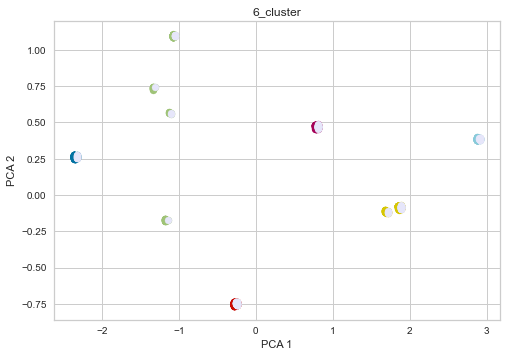

In [24]:
label_data = y_train.copy()
cluster_copy = cluster_4.copy()

cluster_num = 6

km = KMeans(n_clusters=cluster_num ,init='k-means++', random_state=42)
km.fit(cluster_copy)

label_data = label_data.replace('유지',0)
label_data = label_data.replace('탈락',1)

cluster_copy['label'] = label_data

cluster_copy['cluster'] = km.labels_

cluster_result = cluster_copy.groupby(['label','cluster'])['AGE'].count()
print(cluster_num,"개로 군집화")
print(cluster_result) # groupby로 정답 분포 확인
print()

if len(cluster_result[1]) >= len(cluster_result[0]):
    length = cluster_result[0].index
else:    
    length = cluster_result[1].index
    
for j in length:
    print(j,"번째 군집 중도탈락 비율 : ",end="")
    p_100(cluster_result[1][j],cluster_result[0][j])
    
# 차원축소
pca = PCA(n_components=2)
pca.fit(cluster_copy)
data_pca = pca.transform(cluster_copy)

print()
print(cluster_num,"개로 군집화")
print(data_pca.shape)
print("설명력 : ",sum(pca.explained_variance_ratio_))

cluster_copy['pca_x'] = data_pca[:,0]
cluster_copy['pca_y'] = data_pca[:,1]

arr = [0 for n in range(cluster_num+1)]

for j in range(0,cluster_num):
    arr[j] = cluster_copy.loc[cluster_copy['cluster'] == j].index

arr[cluster_num] = cluster_copy.loc[cluster_copy['label'] == 1].index   

for j in range(0,len(arr)-1):
    plt.scatter(x=cluster_copy.loc[arr[j],'pca_x'], y=cluster_copy.loc[arr[j],'pca_y'])

plt.scatter(x=cluster_copy.loc[arr[len(arr)-1],'pca_x'], y=cluster_copy.loc[arr[len(arr)-1],'pca_y'], color='lavender')

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
globals()['{}__cluster'.format(cluster_num)] = "{}_cluster".format(cluster_num)
plt.title(globals()['{}__cluster'.format(cluster_num)])
plt.show()

In [25]:
list_cluster = [0]

cluster_4_copy_N = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_4_copy_N

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
6550,0.026006,0.000384,0.000000,0.000605,0.008190,0.008689,0.429775,0.517241,0.369030,0.000000,...,0,1,0,0,0,0,0,0,-2.355633,0.264603
16846,0.028896,0.002109,0.000000,0.000942,0.005793,0.114159,0.000000,0.275862,0.257396,0.020619,...,0,1,0,0,0,0,0,0,-2.358023,0.270904
18323,0.008027,0.000537,0.000000,0.000515,0.005793,0.008344,0.000000,0.183908,0.369030,0.072165,...,0,1,0,0,0,0,0,0,-2.357825,0.272012
19512,0.011237,0.000798,0.000000,0.000513,0.005793,0.009789,0.000000,0.620690,0.332509,0.041237,...,0,1,0,0,0,0,0,0,-2.356783,0.260679
15620,0.462336,0.001463,0.000000,0.000372,0.001064,0.007067,0.000000,0.379310,0.123834,0.030928,...,0,1,0,0,0,0,0,0,-2.359145,0.264309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19115,0.028361,0.000308,0.000000,0.000459,0.008135,0.423100,0.562358,0.689655,0.475799,0.257732,...,0,1,0,0,0,0,0,0,-2.352103,0.264637
15265,0.004816,0.000619,0.000000,0.001773,0.000019,0.036201,0.132785,0.402299,0.369030,0.030928,...,0,1,0,0,0,0,0,0,-2.357982,0.264372
8006,0.016856,0.001598,0.333333,0.000713,0.007527,0.073524,0.000000,0.494253,0.369030,0.020619,...,0,1,0,0,0,0,0,0,-2.356527,0.257484


In [26]:
list_cluster = [4, 5]

cluster_4_copy_Y = extraction_func(cluster_copy,'cluster',list_cluster)

cluster_4_copy_Y

,DISTANCE,PAYM_AMT,CHLD_CNT,SUM_ORIG_PREM,TOTALPREM,HOUSE_HOSP_DIST,RCBASE_HSHD_INCM,AGE,CUST_RGST,CLAIM_NUM,...,CUST_ROLE_1,CUST_ROLE_2,CUST_ROLE_21,CUST_ROLE_3,CUST_ROLE_4,CUST_ROLE_5,label,cluster,pca_x,pca_y
index,,,,,,,,,,,,,,,,,,,,,
15027,0.009632,0.001177,0.000000,0.000205,0.005793,0.008766,0.000000,0.287356,0.361694,0.061856,...,0,1,0,0,0,0,1,4,1.887886,-0.077452
17965,0.004816,0.000571,0.000000,0.000338,0.005793,0.003696,0.237077,0.068966,0.189379,0.134021,...,0,1,0,0,0,0,0,4,1.853977,-0.074780
13633,0.010435,0.008062,0.166667,0.000500,0.008606,0.008150,0.267386,0.620690,0.369030,0.010309,...,0,1,0,0,0,0,0,4,1.857889,-0.093506
2234,0.210700,0.000549,0.666667,0.000583,0.008193,0.009789,0.313682,0.505747,0.369030,0.000000,...,0,1,0,0,0,0,0,4,1.859105,-0.099629
15410,0.008027,0.001723,0.000000,0.001267,0.007527,0.002178,0.000000,0.517241,0.369030,0.030928,...,0,1,0,0,0,0,0,4,1.682431,-0.116612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15328,0.041739,0.000849,0.000000,0.000222,0.009048,0.029862,0.269706,0.459770,0.330117,0.000000,...,0,1,0,0,0,0,0,5,2.878679,0.386839
10893,0.001605,0.000949,0.333333,0.000767,0.001192,0.006695,0.000000,0.517241,0.369030,0.010309,...,0,1,0,0,0,0,0,5,2.880674,0.381930
9637,0.019799,0.001174,0.166667,0.001140,0.008103,0.016854,0.142115,0.413793,0.369030,0.051546,...,0,1,0,0,0,0,1,5,2.909763,0.388083


## 추출한 데이터 합치기

In [28]:
print(len(cluster_0_copy_N))
print(len(cluster_0_copy_Y))
print(len(cluster_1_copy_Y))
print(len(cluster_1_copy_N))
print(len(cluster_2_copy_N))
print(len(cluster_2_copy_Y))
print(len(cluster_3_copy_N))
print(len(cluster_4_copy_Y))
print(len(cluster_4_copy_N))

710
529
1517
803
478
453
2696
447
420


In [45]:
N_data_feature = pd.concat([ cluster_0_copy_N,cluster_1_copy_N,cluster_2_copy_N,cluster_3_copy_N,cluster_4_copy_N], axis=0).iloc[:,:31]
Y_data_feature = pd.concat([ cluster_0_copy_Y,cluster_1_copy_Y,cluster_2_copy_Y,cluster_4_copy_Y], axis=0).iloc[:,:31]

y_train_copy = y_train.copy()

N_data_label = y_train_copy.loc[N_data_feature.index]
Y_data_label = y_train_copy.loc[Y_data_feature.index]

data_feature = pd.concat([N_data_feature,Y_data_feature],axis=0)
data_label = pd.concat([N_data_label,Y_data_label],axis=0)

print(data_feature.shape)

(8053, 31)


### 데이터 확인하기
 - 보험사기자가 아닌 집단은 보험사기자가 3%이다.
 - 보험사지가 집단은 보험사기자가 16.7%이다.
 - 최종 훈련데이터의 보험사기자는 8%이다.

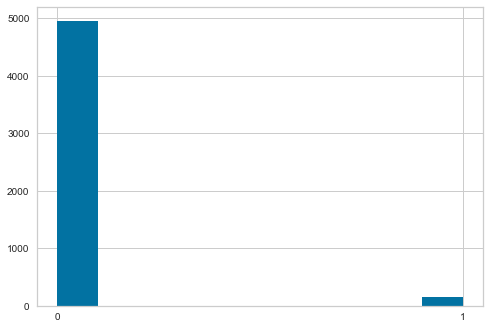

SIU_CUST_YN
0              4952
1               155
dtype: int64
3.04 %
None


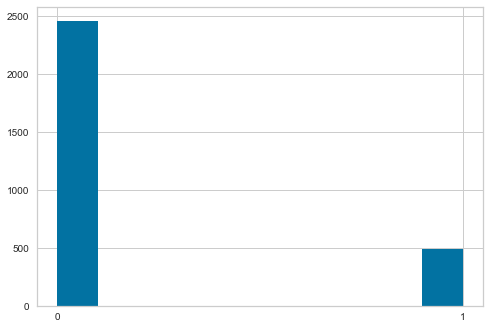

SIU_CUST_YN
0              2454
1               492
dtype: int64
16.7 %
None


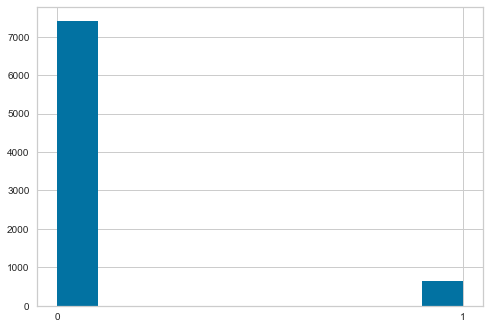

SIU_CUST_YN
0              7406
1               647
dtype: int64
8.03 %
None


In [48]:
plt.hist(N_data_label)
plt.xticks([0,1])
plt.show()

print(N_data_label.value_counts())
print(p_100(N_data_label.value_counts()[1],N_data_label.value_counts()[0]))

plt.hist(Y_data_label)
plt.xticks([0,1])
plt.show()

print(Y_data_label.value_counts())
print(p_100(Y_data_label.value_counts()[1],Y_data_label.value_counts()[0]))

plt.hist(data_label)
plt.xticks([0,1])
plt.show()

print(data_label.value_counts())
print(p_100(data_label.value_counts()[1],data_label.value_counts()[0]))

### 데이터 저장하기

In [49]:
data_feature.to_csv('./temp_data/save_data_feature.csv',index = True)
data_label.to_csv('./temp_data/save_data_label.csv',index = True)